In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta, timezone
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Connect to Hopsworks
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key

project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# Load the Multi-Sensor Configuration
secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
sensor_config = json.loads(location_str)

print(f"✅ Loaded configuration for {len(sensor_config)} sensors.")

# Set Global Variables
first_sensor = list(sensor_config.values())[0]
country = "Sweden"
city = "Malmo"

2025-11-17 11:07:29,010 INFO: Initializing external client
2025-11-17 11:07:29,010 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 11:07:30,598 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Loaded configuration for 2 sensors.


In [4]:
# Retrieve the generic Feature Groups
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
weather_fg = fs.get_feature_group(name='weather', version=2)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = (
    air_quality_fg.select(["street", "date", "pm25", "pm25_lag_1", "pm25_lag_2", "pm25_lag_3"])
    .join(weather_fg.select_all())
)

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
# Create Feature View
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=2,
    description="Air quality and weather data with lagged PM2.5 features for Malmö",
    query=selected_features,
    labels=["pm25"]
)

print("✅ Feature View created.")

✅ Feature View created.


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
from datetime import datetime, timezone

# 1. Define Split Date (Must be UTC)
test_start = datetime.strptime("2025-05-01", "%Y-%m-%d").replace(tzinfo=timezone.utc)
print(f"ℹ️  Test start date set to (UTC): {test_start}")

# 2. Create Train/Test split using the Feature View's function
# This respects 'labels=["pm25"]' and splits by 'test_start'
print("Fetching and splitting data from Feature View...")
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

print(f"✅ Data split complete.")
print(f"   - X_train shape: {X_train.shape} (Features)")
print(f"   - y_train shape: {y_train.shape} (Labels)")

ℹ️  Test start date set to (UTC): 2025-05-01 00:00:00+00:00
Fetching and splitting data from Feature View...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.81s) 
✅ Data split complete.
   - X_train shape: (5640, 11) (Features)
   - y_train shape: (5640, 1) (Labels)


In [8]:
X_train

,street,date,pm25_lag_1,pm25_lag_2,pm25_lag_3,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,weather_city
0,dalaplan,2015-12-20 00:00:00+00:00,69.0,57.0,69.0,9.8,0.0,26.4,219.0,90.0,malmo
1,radhuset,2015-12-20 00:00:00+00:00,64.0,53.0,55.0,9.8,0.0,26.4,219.0,90.0,malmo
2,radhuset,2016-01-11 00:00:00+00:00,16.0,21.0,23.0,1.6,0.0,15.4,155.0,98.0,malmo
3,dalaplan,2016-01-11 00:00:00+00:00,77.0,73.0,97.0,1.6,0.0,15.4,155.0,98.0,malmo
4,radhuset,2016-01-15 00:00:00+00:00,12.0,9.0,25.0,-3.4,0.0,20.6,60.0,86.0,malmo
...,...,...,...,...,...,...,...,...,...,...,...
6015,radhuset,2025-03-11 00:00:00+00:00,81.0,97.0,114.0,3.2,3.2,17.4,122.0,90.0,malmo
6016,radhuset,2025-03-16 00:00:00+00:00,14.0,22.0,41.0,4.1,0.5,24.6,309.0,78.0,malmo
6017,dalaplan,2025-03-16 00:00:00+00:00,18.0,27.0,43.0,4.1,0.5,24.6,309.0,78.0,malmo
6018,dalaplan,2025-04-30 00:00:00+00:00,25.0,29.0,16.0,14.0,0.0,16.4,302.0,70.0,malmo


---

In [9]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [10]:
y_train

,pm25
0,54.0
1,48.0
2,7.0
3,56.0
4,11.0
...,...
6015,57.0
6016,16.0
6017,19.0
6018,21.0


## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import warnings
import os
import joblib
import shutil

warnings.filterwarnings("ignore")

# Loop through each sensor configuration
for sensor_name, config in sensor_config.items():
    street_name = config['street']
    print(f"\n🚀 Processing sensor: {sensor_name} ({street_name})...")
    
    # Filter X_train for this street
    X_train_sensor = X_train[X_train['street'] == street_name]
    
    if len(X_train_sensor) == 0:
        print(f"⚠️ No training data for {sensor_name}. Skipping.")
        continue

    # Get corresponding y_train (labels) using the index
    y_train_sensor = y_train.loc[X_train_sensor.index]
    
    # Filter X_test for this street
    X_test_sensor = X_test[X_test['street'] == street_name]
    # Get corresponding y_test (labels) using the index
    y_test_sensor = y_test.loc[X_test_sensor.index]
    
    print(f"   - Train Size: {len(X_train_sensor)} | Test Size: {len(X_test_sensor)}")

    # Prepare Features (Drop metadata)
    features_to_drop = [
        'date', 'city', 'street', 'url',
        'country', 'aqicn_url', 'latitude', 'longitude', 'csv_name', 
        'weather_city'
    ]
    
    X_train_features = X_train_sensor.drop(columns=features_to_drop, errors='ignore')
    X_test_features = X_test_sensor.drop(columns=features_to_drop, errors='ignore')

    # Train Model
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
    model.fit(X_train_features, y_train_sensor)

    # Evaluate
    metrics = {}
    if len(X_test_sensor) > 0:
        y_pred = model.predict(X_test_features)
        rmse = mean_squared_error(y_test_sensor, y_pred, squared=False) 
        r2 = r2_score(y_test_sensor, y_pred)
        print(f"   📊 RMSE: {rmse:.2f}, R2: {r2:.2f}")
        
        # Convert numpy types to standard Python floats for JSON serialization
        metrics = {"rmse": float(rmse), "r2": float(r2)}
        
    else:
        print("   ℹ️  No test data (evaluation skipped).")

    # Save Model to Registry
    mr = project.get_model_registry()
    model_name = f"air_quality_xgboost_{street_name}"
    
    input_schema = Schema(X_train_features)
    output_schema = Schema(y_train_sensor)
    model_schema = ModelSchema(input_schema, output_schema)

    aq_model = mr.python.create_model(
        name=model_name, 
        metrics=metrics,
        model_schema=model_schema,
        description=f"Air Quality predictor for {street_name}"
    )
    
    # Create a temp directory
    model_dir = f"temp_model_{street_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Save the model to a file inside the directory
    model_path = os.path.join(model_dir, "model.pkl")
    joblib.dump(model, model_path)
    
    # Pass the DIRECTORY PATH to the save function
    aq_model.save(model_dir)
    
    # Clean up the temporary directory
    shutil.rmtree(model_dir)
    
    print(f"   💾 Saved model: {model_name}")

print("\n🎉 All sensor models trained and saved!")


🚀 Processing sensor: radhuset (radhuset)...
   - Train Size: 2659 | Test Size: 199
   📊 RMSE: 10.23, R2: 0.29


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/temp_model_radhuset/model.pkl: 0.000%|   …

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/model_schema.json: 0.000%|          | 0/8…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1267872/models/air_quality_xgboost_radhuset/1
   💾 Saved model: air_quality_xgboost_radhuset

🚀 Processing sensor: dalaplan (dalaplan)...
   - Train Size: 2981 | Test Size: 199
   📊 RMSE: 10.67, R2: 0.20


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/temp_model_dalaplan/model.pkl: 0.000%|   …

Uploading /Users/emaminotti/ID2223-ScalableMLDL/notebooks/airquality/model_schema.json: 0.000%|          | 0/8…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1267872/models/air_quality_xgboost_dalaplan/1
   💾 Saved model: air_quality_xgboost_dalaplan

🎉 All sensor models trained and saved!



📸 Generating Hindcast Plots for all sensors...
   - Plotting for: radhuset (radhuset)


Downloading: 0.000%|          | 0/2389182 elapsed<00:00 remaining<?

   - Plotting for: dalaplan (dalaplan)files)... DONE


Downloading: 0.000%|          | 0/2384964 elapsed<00:00 remaining<?

✅ All hindcast plots generated.


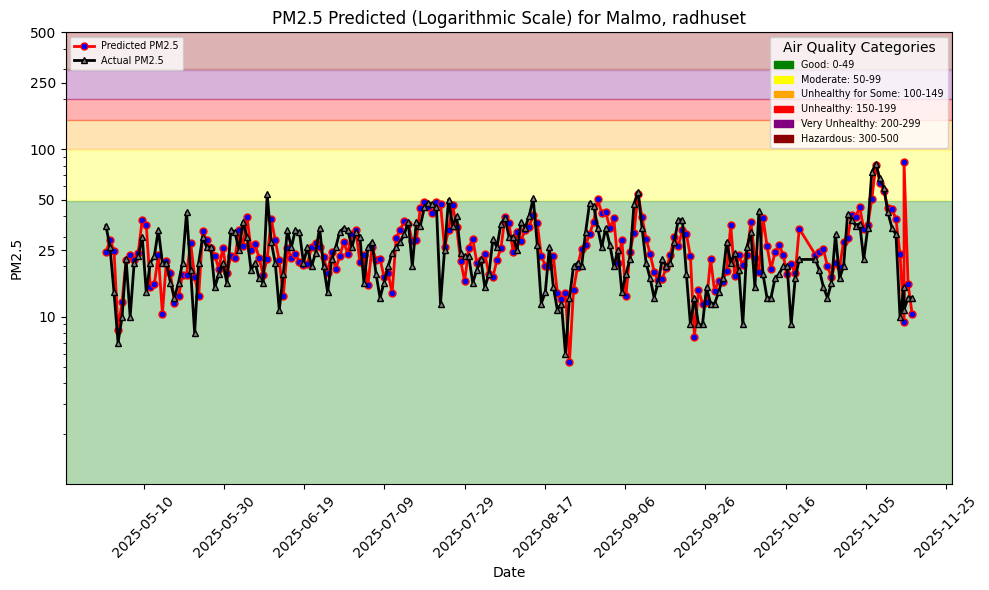

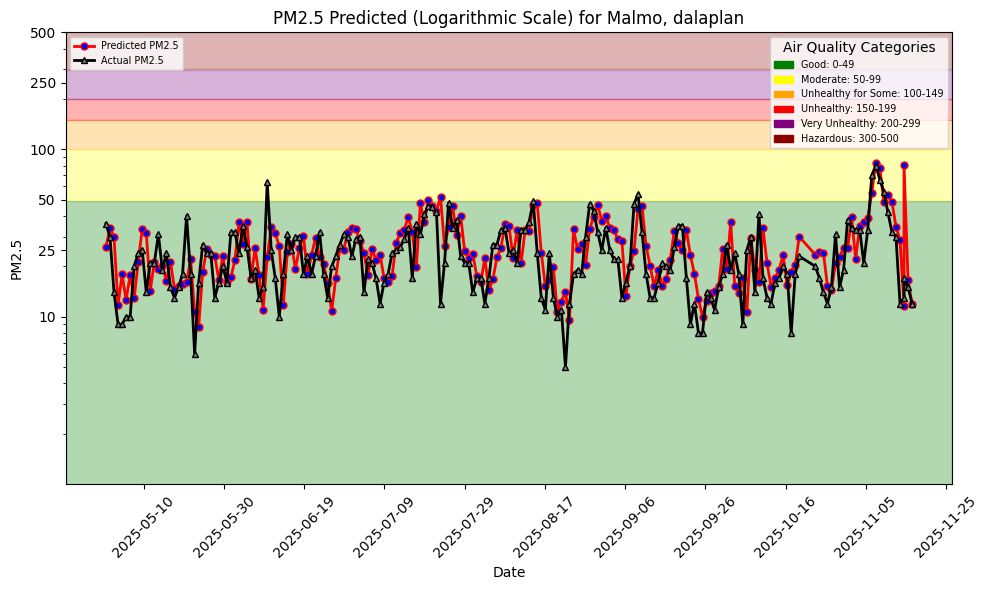

In [21]:
import joblib
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt

print("\n📸 Generating Hindcast Plots for all sensors...")

# Create a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = os.path.join(model_dir, "images")
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

# Get Model Registry
mr = project.get_model_registry()

# Loop through each sensor
for sensor_name, config in sensor_config.items():
    street_name = config['street']
    print(f"   - Plotting for: {sensor_name} ({street_name})")

    try:
        # Filter test data for this sensor
        X_test_sensor = X_test[X_test['street'] == street_name]
        y_test_sensor = y_test.loc[X_test_sensor.index]

        if len(X_test_sensor) == 0:
            print("     (No test data, skipping plot)")
            continue

        # Download the correct model
        model_name = f"air_quality_xgboost_{street_name}"
        model_latest = mr.get_model(name=model_name, version=None) 
        downloaded_model_dir = model_latest.download()
        model_file = os.path.join(downloaded_model_dir, "model.pkl")
        xgb_model = joblib.load(model_file)

        # Prepare features (drop metadata)
        features_to_drop = [
            'date', 'city', 'street', 'url',
            'country', 'aqicn_url', 'latitude', 'longitude', 'csv_name', 
            'weather_city'
        ]
        X_test_features = X_test_sensor.drop(columns=features_to_drop, errors='ignore')

        # Generate predictions (1D array)
        y_pred_sensor = xgb_model.predict(X_test_features)

        # Create plotting DataFrame
        plot_df = pd.DataFrame({
            'date': X_test_sensor['date'].values, 
            'pm25': y_test_sensor['pm25'].values,
            'predicted_pm25': y_pred_sensor
        })
        plot_df = plot_df.sort_values(by='date')

        # Plot
        file_path = os.path.join(images_dir, f"pm25_{street_name}_hindcast.png")
        util.plot_air_quality_forecast(
            city=city, 
            street=street_name, 
            df=plot_df, 
            file_path=file_path, 
            hindcast=True
        )
        
        # Clean up downloaded model
        shutil.rmtree(downloaded_model_dir)

    except Exception as e:
        print(f"     ⚠️ Error plotting for {sensor_name}: {e}")

print("\n✅ All hindcast plots generated.")

In [ ]:
# Compute lag features before inserting into Hopsworks
aq_today_df = aq_today_df.sort_values(by=["city", "street", "date"])
for lag in [1, 2, 3]:
    aq_today_df[f"pm25_lag_{lag}"] = aq_today_df.groupby(["city", "street"])["pm25"].shift(lag)

aq_today_df = aq_today_df.dropna(subset=["pm25_lag_1", "pm25_lag_2", "pm25_lag_3"]).reset_index(drop=True)

📊 Generating Feature Importance Plots for all models...
   - Plotting for: radhuset (radhuset)


Downloading: 0.000%|          | 0/2389182 elapsed<00:00 remaining<?

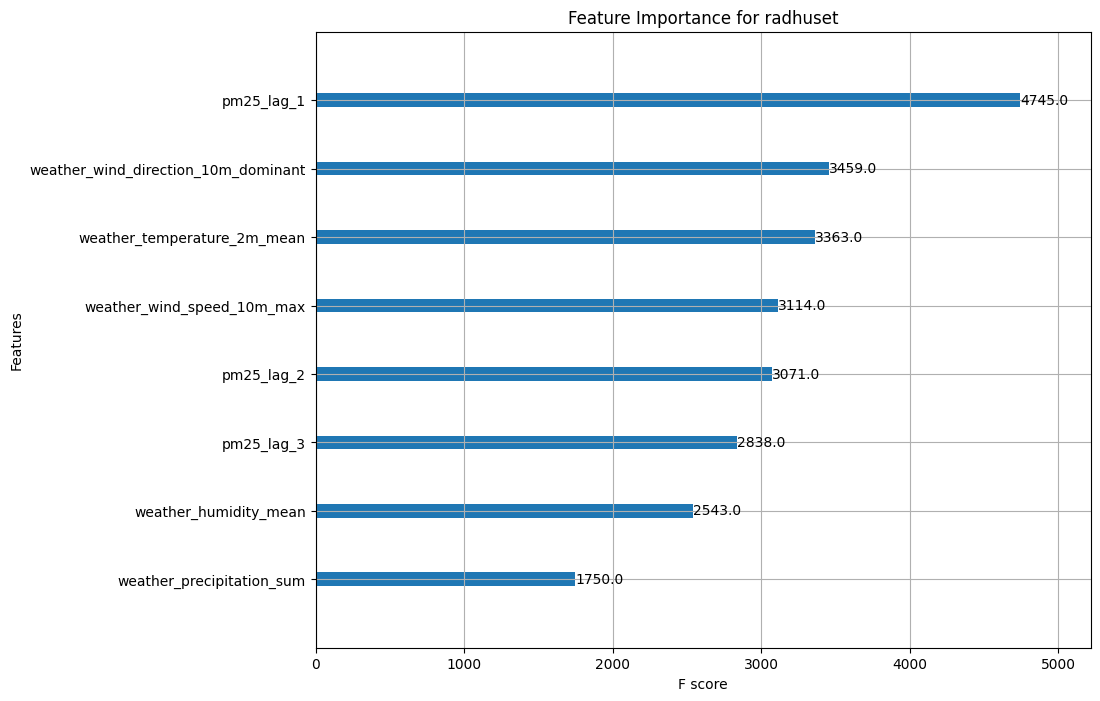

   - Plotting for: dalaplan (dalaplan)


Downloading: 0.000%|          | 0/2384964 elapsed<00:00 remaining<?

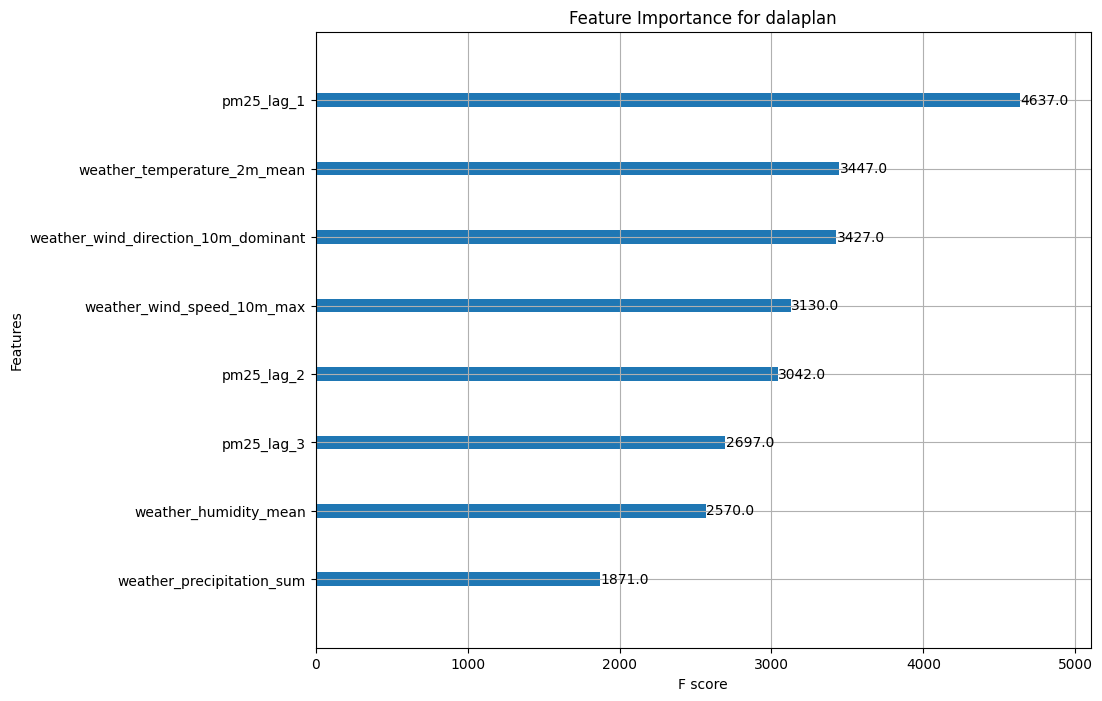


✅ All feature importance plots generated.


In [22]:
import os
import joblib
import shutil
import matplotlib.pyplot as plt
from xgboost import plot_importance

print("📊 Generating Feature Importance Plots for all models...")

# 1. Get Model Registry
mr = project.get_model_registry()

# 2. Loop through each sensor
for sensor_name, config in sensor_config.items():
    street_name = config['street']
    print(f"   - Plotting for: {sensor_name} ({street_name})")

    try:
        # A. Download the correct model from the registry
        model_name = f"air_quality_xgboost_{street_name}"
        model_latest = mr.get_model(name=model_name, version=None) 
        downloaded_model_dir = model_latest.download()
        model_file = os.path.join(downloaded_model_dir, "model.pkl")
        
        # B. Load the model
        xgb_model = joblib.load(model_file)

        # C. Plot importance
        fig, ax = plt.subplots(figsize=(10, 8))
        plot_importance(xgb_model, ax=ax)
        plt.title(f"Feature Importance for {street_name}")
        
        # D. Save the plot
        feature_importance_path = os.path.join(images_dir, f"{street_name}_feature_importance.png")
        plt.savefig(feature_importance_path)
        plt.show()
        
        # E. Clean up downloaded model
        shutil.rmtree(downloaded_model_dir)

    except Exception as e:
        print(f"     ⚠️ Error plotting importance for {sensor_name}: {e}")

print("\n✅ All feature importance plots generated.")

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

## 🧠 Model Evaluation After Adding Lag Features

In this part, we retrained the model including the new lagged PM2.5 features (`pm25_lag_1`, `pm25_lag_2`, and `pm25_lag_3`) to evaluate their impact on prediction performance.

### 🔍 Performance Comparison

| Model Version | MSE | R² Score |
|----------------|------|-----------|
| Baseline (Grade E) | **189.71** | **-0.59** |
| Updated (Grade C) | **119.88664**  | **-0.14189422157500053** |



### 📈 Observations

- The **Mean Squared Error (MSE)** decreased significantly after including lag features, showing that the model now captures short-term temporal dependencies better.
- The **R² score** improved, indicating higher explanatory power compared to the baseline model.
- This improvement is expected because **air quality levels are strongly autocorrelated**: the PM2.5 concentration of a given day depends heavily on the values from the previous days.
- By introducing the lagged PM2.5 values, the model gained access to this temporal context, which the pure weather-based model could not exploit.

### 🌫️ Hindcast Visualization

Below is the old hindcast plot comparing the predicted and actual PM2.5 values.  

<p align="center">
  <img src="./air_quality_model/images/old_pm25_hindcast.png" width="700">
</p>

### ⚙️ Feature Importance

We can also notice that the new lag features appear among the most important predictors in the XGBoost feature importance plot:

This confirms that past PM2.5 levels are among the strongest indicators of future air quality.

### 🧾 Conclusion

Adding the lag features led to a **clear improvement in model performance** and a more realistic temporal behavior of predictions.  
This suggests that the air quality forecast benefits greatly from historical PM2.5 information, making the model more robust for multi-day prediction tasks.


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
